# Imports

In [1]:
import numpy as np
from tqdm import tqdm

import plottable
from plottable import ColumnDefinition, Table

import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, TimeDistributed
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# Load the data

In [2]:
df_games = pd.read_csv('data/games.csv')
df_players = pd.read_csv('data/players.csv')
df_plays = pd.read_csv('data/plays.csv')
df_tackles = pd.read_csv('data/tackles.csv')

df_tracking = pd.DataFrame()
for week in range(1, 10):
    file_name = f'data/tracking_week_{week}.csv'
    df_tmp = pd.read_csv(file_name)
    df_tracking = pd.concat([df_tracking, df_tmp], ignore_index=True)

In [3]:
df_plays.insert(0, 'key', df_plays['gameId'].astype(str) + df_plays['playId'].astype(str))
df_plays['key'] = df_plays['key'].astype(int)
df_tackles.insert(0, 'key', df_tackles['gameId'].astype(str) + df_tackles['playId'].astype(str))
df_tackles['key'] = df_tackles['key'].astype(int)
df_tracking.insert(0, 'key', df_tracking['gameId'].astype(str) + df_tracking['playId'].astype(str))
df_tracking['key'] = df_tracking['key'].astype(int)

# Data Cleaning
* removed
    * missed tackles
    * plays with a foul
    * fumbles
    * sacks
    * plays with touchdown
    * frames after event of tackle or end of play (the last four frames of a play)

In [4]:
# Removing Missed Tackles and Fumbles
if 'pff_missedTackle' in df_tackles.columns:
    df = df_tackles.query('not pff_missedTackle==1 and not forcedFumble==1').iloc[:,:-2]

In [5]:
# Remove penalty plays
cols=['key','foulName1','playNullifiedByPenalty']
df = df.merge(df_plays[cols], on='key', how='left').query('foulName1.isna() and playNullifiedByPenalty=="N"').drop(['foulName1','playNullifiedByPenalty'],axis=1)

In [6]:
df.rename({'nflId':'tacklerId'}, axis=1, inplace=True)

In [7]:
cols=['key','ballCarrierId','playResult','absoluteYardlineNumber']
df = df.merge(df_plays[cols], on='key', how='left')

In [8]:
df = df[['key', 'gameId', 'playId', 'tacklerId', 'ballCarrierId', 'tackle', 'assist','playResult','absoluteYardlineNumber']]

In [9]:
# Double checking to make sure not touchdown plays -> Yay! No tackles are touchdowns 
cols=['key','event']
df.merge(df_tracking.query('event=="touchdown"')[cols], on='key', how='left').query('event=="touchdown"').shape[0]

0

In [10]:
# Add play direction to main dataframe
cols = ['key','playDirection']
df = df.merge(df_tracking.drop_duplicates(subset='key')[cols], on='key', how='left')

In [11]:
df['x_final'] = df.apply(lambda row: row['absoluteYardlineNumber'] + row['playResult'] if row['playDirection'] == 'right' else row['absoluteYardlineNumber'] - row['playResult'], axis=1)

In [12]:
# Remove play where tackle was incorrectly assigned
# 20220918073597: intentional safety to end game -> -26 yard tackle

drop_keys = [20220925103356,20220918073597]
for key in  drop_keys:
    if key in df.key.unique():
        df = df.query('key!=@key')

In [13]:
# Remove missed fumble plays and QB Sacks
events = ['fumble','fumble_defense_recovered','fumble_offense_recovered','qb_sack']
df = df.merge(df_tracking.query("event in @events").drop_duplicates('key')[['key','event']],on='key',how='left').query('event.isna()')
df.drop('event',inplace=True,axis=1)

In [15]:
keys = df.key.unique()
eventCounts = {}
for key in tqdm(keys):
    frameId_max = df_tracking.query('key==@key').frameId.unique().max()
    event = df_tracking.query('key==@key').head(frameId_max).reset_index(drop=True).event[frameId_max-5]
    if event in eventCounts.keys():
        eventCounts[event] += 1
    else:
        eventCounts[event] = 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11214/11214 [08:08<00:00, 22.95it/s]


In [16]:
eventCounts

{'tackle': 9543, 'out_of_bounds': 1545, 'qb_slide': 122, 'safety': 1, nan: 3}

In [17]:
# Find the 3 keys that are nan
keys = df.key.unique()
nanKeys = []
for key in tqdm(keys):
    frameId_max = df_tracking.query('key==@key').frameId.unique().max()
    event = df_tracking.query('key==@key').head(frameId_max).reset_index(drop=True).event[frameId_max-5]
    if not event == event:
        nanKeys.append(key)

keys_without_5_frames_after = [202209180163, 20221016052970, 20221023071505]
keys_without_5_frames_after

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11214/11214 [07:40<00:00, 24.34it/s]


[202209180163, 20221016052970, 20221023071505]

In [18]:
# Remove last five frames of play, since 4 extra frames are recorded after end of play event (tackle, ob, ...)
keys = df.key.unique()
filtered_dfs = []

for key in tqdm(keys):
    df_qry = df_tracking[df_tracking['key'] == key]
    
    if key not in keys_without_5_frames_after:
        frameId_max = df_qry['frameId'].max() - 4
    else:
        frameId_max = df_qry['frameId'].max()
        
    filtered_dfs.append(df_qry[df_qry['frameId'] <= frameId_max])

df_tracking_new = pd.concat(filtered_dfs, axis=0).reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11214/11214 [00:57<00:00, 196.16it/s]


In [19]:
df_tracking_new.head()

,key,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800101,2022090800,101,35472.0,Rodger Saffold,1,2022-09-08 20:25:08.200000,76.0,BUF,left,73.13,27.64,0.01,0.01,0.00,267.95,182.22,NaN
1,2022090800101,2022090800,101,35472.0,Rodger Saffold,2,2022-09-08 20:25:08.299999,76.0,BUF,left,73.13,27.64,0.01,0.01,0.00,267.95,182.56,NaN
2,2022090800101,2022090800,101,35472.0,Rodger Saffold,3,2022-09-08 20:25:08.400000,76.0,BUF,left,73.13,27.63,0.01,0.01,0.00,267.95,182.15,NaN
3,2022090800101,2022090800,101,35472.0,Rodger Saffold,4,2022-09-08 20:25:08.500000,76.0,BUF,left,73.13,27.64,0.00,0.01,0.01,274.37,179.54,NaN
4,2022090800101,2022090800,101,35472.0,Rodger Saffold,5,2022-09-08 20:25:08.599999,76.0,BUF,left,73.13,27.65,0.00,0.25,0.01,274.95,1.03,NaN


In [20]:
df.reset_index(drop=True, inplace=True)

In [21]:
# Normalize Tracking data to all go towards the right
left_condition = df_tracking_new['playDirection'] == 'left'
df_tracking_new.loc[left_condition, 'x'] = 110 - df_tracking_new.loc[left_condition, 'x']
df_tracking_new.loc[left_condition, 'y'] = 53.3 - df_tracking_new.loc[left_condition, 'y']

In [22]:
cols = ['playDirection','time']
for col in cols:
    if col in df_tracking_new.columns:
        df_tracking_new.drop(col, inplace=True, axis=1)

In [23]:
# Normalize tackle data to all go towards the right
left_condition = df['playDirection'] == 'left'
df.loc[left_condition, 'absoluteYardlineNumber'] = 110 - df.loc[left_condition, 'absoluteYardlineNumber']

In [24]:
cols = ['x_final','playDirection','tackle','assist']
for col in cols:
    if col in df.columns:
        df.drop(col, inplace=True, axis=1)

In [25]:
df_new = df.merge(df_tracking_new.drop_duplicates(['key','frameId'],ignore_index=True)[['key','frameId']],how='left',on='key')

In [26]:
df_new = df_new[['gameId', 'playId', 'frameId', 'tacklerId', 'ballCarrierId',
                 'absoluteYardlineNumber','playResult']]

In [27]:
x = df_new.iloc[:,:-1]
y = df_new[['gameId', 'playId', 'frameId', 'playResult']]

# Feature Engineering

In [28]:
track_cols = ['gameId','playId','frameId','nflId','x','y','s','a','dis','o','dir']
track_rename = {
    'nflId':'tacklerId',
    'x':'x_tackler',
    'y':'y_tackler',
    's':'s_tackler',
    'a':'a_tackler',
    'dis':'dis_tackler',
    'o':'o_tackler',
    'dir':'dir_tackler'}

x = x.merge(df_tracking_new[track_cols].rename(track_rename,axis=1),
            on=['gameId','playId','frameId','tacklerId'], 
            how='left')

In [29]:
track_cols = ['gameId','playId','frameId','nflId','x','y','s','a','dis','o','dir']
track_rename = {
    'nflId':'ballCarrierId',
    'x':'x_ballCarrier',
    'y':'y_ballCarrier',
    's':'s_ballCarrier',
    'a':'a_ballCarrier',
    'dis':'dis_ballCarrier',
    'o':'o_ballCarrier',
    'dir':'dir_ballCarrier'}

x = x.merge(df_tracking_new[track_cols].rename(track_rename,axis=1),
            on=['gameId','playId','frameId','ballCarrierId'], 
            how='left')

In [30]:
# drop plays without matching tracking data (probably dropped)
x = x[~x.x_ballCarrier.isna() & ~x.x_tackler.isna()]

In [31]:
x['dist_ballCarrier_tackler'] = np.sqrt((x['x_tackler'] - x['x_ballCarrier'])**2 + (x['y_tackler'] - x['y_ballCarrier'])**2)

In [32]:
x['tacklerDepth'] = x['x_tackler'] - x['absoluteYardlineNumber']
x['ballCarrierDepth'] = x['x_ballCarrier'] - x['absoluteYardlineNumber']

In [33]:
# Convergence rate based on euclidean distance
x.sort_values(by=['gameId', 'playId', 'frameId'], inplace=True)
x.reset_index(drop=True,inplace=True)
x['prev_distance'] = x.groupby(['gameId', 'playId'])['dist_ballCarrier_tackler'].shift(1)
x['convergence_rate'] = x['prev_distance'] / x['dist_ballCarrier_tackler']
x['convergence_rate'].fillna(1, inplace=True)
x.drop(columns=['prev_distance'], inplace=True)

In [34]:
x['dist_ballCarrier_tackler_x'] = x['x_tackler'] - x['x_ballCarrier']

In [35]:
# Convergence rate only on x-axis (latitude)
x.sort_values(by=['gameId', 'playId', 'frameId'], inplace=True)
x.reset_index(drop=True,inplace=True)
x['prev_distance_x'] = x.groupby(['gameId', 'playId'])['dist_ballCarrier_tackler_x'].shift(1)
x['convergence_rate_x'] = x['prev_distance_x'] / x['dist_ballCarrier_tackler_x']
x['convergence_rate_x'].fillna(1, inplace=True)
x.drop(columns=['prev_distance_x'], inplace=True)

In [36]:
x['o_diff'] = x['o_tackler'] - x['o_ballCarrier']
x['dir_diff'] = x['dir_tackler'] - x['dir_ballCarrier']

In [37]:
# Convert degrees to radians
x['o_tackler_rad'] = np.radians(x['o_tackler'])
x['o_ballCarrier_rad'] = np.radians(x['o_ballCarrier'])
x['dir_tackler_rad'] = np.radians(x['dir_tackler'])
x['dir_ballCarrier_rad'] = np.radians(x['dir_ballCarrier'])

# Calculate the sine of the angles
x['sin_o_tackler'] = np.sin(x['o_tackler_rad'])
x['sin_o_ballCarrier'] = np.sin(x['o_ballCarrier_rad'])
x['sin_dir_tackler'] = np.sin(x['dir_tackler_rad'])
x['sin_dir_ballCarrier'] = np.sin(x['dir_ballCarrier_rad'])

# Perform the subtraction
x['sin_o_sum'] = x['sin_o_tackler'] + x['sin_o_ballCarrier']
x['sin_dir_sum'] = x['sin_dir_tackler'] + x['sin_dir_ballCarrier']

In [38]:
# Convergence rate based on euclidean distance
x.sort_values(by=['gameId', 'playId', 'frameId'], inplace=True)
x.reset_index(drop=True,inplace=True)
x['prev_distance'] = x.groupby(['gameId', 'playId'])['dist_ballCarrier_tackler'].shift(1)
x['s_tacklerTowardBallCarrier'] = (x['prev_distance'] - x['dist_ballCarrier_tackler']) / .1
x['s_tacklerTowardBallCarrier'].fillna(0, inplace=True)
x.drop(columns=['prev_distance'], inplace=True)

In [39]:
tqdm.pandas()

def isValidValue(val):
    if val>=-10 and val<=50:
        return True
    else:
        return False

def calculate_intersection(row):
    # Unpack the coordinates and directions
    x1, y1, dir1 = row['x_tackler'], row['y_tackler'], row['dir_tackler']
    x2, y2, dir2 = row['x_ballCarrier'], row['y_ballCarrier'], row['dir_ballCarrier']

    # Convert direction angles to radians
    dir1_rad = np.radians(90 - dir1)
    dir2_rad = np.radians(90 - dir2)

    # Calculate slopes
    try:
        m1 = np.tan(dir1_rad)
        m2 = np.tan(dir2_rad)
    except ValueError as e:
        # Handle vertical lines
        return np.mean([x1, x2]) - row['absoluteYardlineNumber']
        

    # Check for parallel lines
    if m1 == m2:
        return np.mean([x1, x2]) - row['absoluteYardlineNumber']

    # Calculate intersection x-coordinate
    x_inter = (m1 * x1 - m2 * x2 - y1 + y2) / (m1 - m2)
    val = x_inter - row['absoluteYardlineNumber']

    # Check if intersection is in the correct direction
    if (((x_inter >= x1) == (np.cos(dir1_rad) >= 0)) and ((x_inter >= x2) == (np.cos(dir2_rad) >= 0)) and
        isValidValue(val)):
        return val
    else:
        return np.mean([x1, x2]) - row['absoluteYardlineNumber']

# Load your dataframe
# x = pd.read_pickle('path_to_your_dataframe.pkl')

# Apply the function with progress bar
x['expected_intersection_x'] = x.progress_apply(calculate_intersection, axis=1)

# Save the updated dataframe
# x.to_pickle('path_to_save_dataframe.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 588782/588782 [00:08<00:00, 72307.64it/s]


In [40]:
def smooth_values(series, sigma=2):
    return gaussian_filter1d(series, sigma=sigma)
    
x['smoothed_expected_intersection_x'] = x.groupby(['gameId', 'playId'])['expected_intersection_x'].transform(lambda s: smooth_values(s, sigma=2))

In [ ]:
# saved in case I want to start over at this point
x_old = x.copy()

In [41]:
cols = ['gameId', 'playId', 'frameId', 'tacklerId', 'ballCarrierId', 'dist_ballCarrier_tackler',
       'tacklerDepth', 'ballCarrierDepth', 'convergence_rate',
       'dist_ballCarrier_tackler_x', 'convergence_rate_x', 'o_diff',
       'dir_diff', 'dir_tackler_rad', 'dir_ballCarrier_rad', 'dir_tackler',
       'dir_ballCarrier','o_tackler','o_ballCarrier',
       'sin_dir_tackler', 'sin_dir_ballCarrier', 'sin_o_sum', 'sin_dir_sum',
       's_tacklerTowardBallCarrier', 'expected_intersection_x',
       'smoothed_expected_intersection_x']

x = x[cols]

In [42]:
# Only keep y samples corresponding to what is in the x dataset
cols = ['gameId','playId','frameId']
y_old = y.copy()
y = x.merge(y_old.drop_duplicates(cols,ignore_index=True), how='left', on=cols).iloc[:,-1:]

In [43]:
x.drop('ballCarrierId', axis=1, inplace=True)

In [44]:
# Note: I first ran the script 'feature_gen/num_offensive_player_between.py' to generate the pickle file
X_off_player_between = pd.read_pickle('feature_gen/x_updated_num_o_players.pkl')

compositeKey = ['gameId','playId','frameId','tacklerId']
new_cols = ['num_off_player_between']
x = x.merge(X_off_player_between[compositeKey+new_cols], how='left',on=compositeKey)

In [45]:
# Note: I first ran the script 'feature_gen/nearest_defenders_and_offesnive.py' to generate the pickle file
X_clossest_players = pd.read_pickle('feature_gen/x_updated.pkl')

compositeKey = ['gameId','playId','frameId','tacklerId']
new_cols = ['closest_defender_1', 'closest_defender_2', 'closest_defender_3',
            'closest_offensive_1', 'closest_offensive_2', 'closest_offensive_3',
            'ballcarrier_closest_indicator']
x = x.merge(X_clossest_players[compositeKey+new_cols], how='left',on=compositeKey)

In [46]:
x.head()

,gameId,playId,frameId,tacklerId,dist_ballCarrier_tackler,tacklerDepth,ballCarrierDepth,convergence_rate,dist_ballCarrier_tackler_x,convergence_rate_x,o_diff,dir_diff,dir_tackler_rad,dir_ballCarrier_rad,dir_tackler,dir_ballCarrier,o_tackler,o_ballCarrier,sin_dir_tackler,sin_dir_ballCarrier,sin_o_sum,sin_dir_sum,s_tacklerTowardBallCarrier,expected_intersection_x,smoothed_expected_intersection_x,num_off_player_between,closest_defender_1,closest_defender_2,closest_defender_3,closest_offensive_1,closest_offensive_2,closest_offensive_3,ballcarrier_closest_indicator
0,2022090800,56,1,43294,3.636289,7.05,4.40,1.000000,2.65,1.000000,-0.51,-16.88,3.010693,3.305305,172.50,189.38,139.54,140.05,0.130526,-0.162982,1.291036,-0.032455,0.000000,5.725,5.769791,0,7.302089,10.278803,13.253396,3.636289,8.862878,9.949418,1
1,2022090800,56,2,43294,3.528810,6.98,4.52,1.030458,2.46,1.077236,5.92,-17.48,3.029892,3.334975,173.60,191.08,140.14,134.22,0.111469,-0.192179,1.357581,-0.080710,1.074793,5.750,5.789183,0,6.834764,10.286622,12.521294,3.528810,7.433794,8.855399,1
2,2022090800,56,3,43294,3.413210,6.94,4.66,1.033869,2.28,1.078947,16.49,-18.97,3.061831,3.392920,175.43,194.40,143.65,127.16,0.079677,-0.248690,1.389668,-0.169013,1.156004,5.800,5.825853,0,6.345589,10.250137,11.750426,3.413210,5.464795,8.867581,1
3,2022090800,56,4,43294,3.258543,6.90,4.81,1.047465,2.09,1.090909,22.93,-20.32,3.083124,3.437775,176.65,196.97,143.65,120.72,0.058435,-0.291871,1.452390,-0.233436,1.546670,5.855,5.876112,0,5.817233,10.171981,10.900073,3.258543,3.289072,8.892497,1
4,2022090800,56,5,43294,3.080260,6.87,4.99,1.057879,1.88,1.111702,23.76,-21.81,3.101974,3.482630,177.73,199.54,141.83,118.07,0.039609,-0.334465,1.500370,-0.294856,1.782829,5.930,5.935473,0,5.279593,10.020005,10.052920,1.904127,3.080260,8.940006,1


In [5]:
# x.to_pickle('./x.pkl')
# y.to_pickle('./y.pkl')

x = pd.read_pickle('./x.pkl')
y = pd.read_pickle('./y.pkl')

### Drop Plays with over 100 plays, as the sample size becomes too small

In [6]:
df_tracking.drop_duplicates(['gameId','playId','frameId']).frameId.value_counts()

frameId
1      12486
2      12486
3      12486
4      12486
5      12486
6      12486
7      12486
8      12485
9      12485
11     12484
10     12484
12     12400
13     12238
14     12087
15     11923
16     11729
17     11546
18     11346
19     11149
20     10959
21     10761
22     10570
23     10360
24     10175
25     10003
26      9808
27      9597
28      9399
29      9168
30      8972
31      8786
32      8599
33      8434
34      8229
35      8056
36      7881
37      7732
38      7566
39      7378
40      7193
41      7006
42      6774
43      6571
44      6331
45      6070
46      5771
47      5449
48      5160
49      4857
50      4569
51      4256
52      3994
53      3720
54      3446
55      3183
56      2920
57      2672
58      2452
59      2232
60      2018
61      1831
62      1659
63      1488
64      1342
65      1220
66      1117
67      1008
68       900
69       798
70       710
71       645
72       593
73       540
74       487
75       440
76       394
77  

In [7]:
max_frameId = df_tracking.groupby(['gameId', 'playId'])['frameId'].max().reset_index()

# Merge this information back into the original dataframe 'df'
x = pd.merge(x, max_frameId, how='left', on=['gameId', 'playId'], suffixes=('', '_max'))
x['frameId_max_new'] = x['frameId_max']- 4

In [9]:
x = x.join(y).query('frameId_max_new <= 100')

In [10]:
y = x.iloc[:,-1:]
x = x.iloc[:,:-3]

In [11]:
columns = x.columns.tolist()
formatted_columns = ",\n".join([f"'{column}'" for column in columns])
print(formatted_columns)

'gameId',
'playId',
'frameId',
'tacklerId',
'dist_ballCarrier_tackler',
'tacklerDepth',
'ballCarrierDepth',
'convergence_rate',
'dist_ballCarrier_tackler_x',
'convergence_rate_x',
'o_diff',
'dir_diff',
'dir_tackler_rad',
'dir_ballCarrier_rad',
'dir_tackler',
'dir_ballCarrier',
'o_tackler',
'o_ballCarrier',
'sin_dir_tackler',
'sin_dir_ballCarrier',
'sin_o_sum',
'sin_dir_sum',
's_tacklerTowardBallCarrier',
'expected_intersection_x',
'smoothed_expected_intersection_x',
'num_off_player_between',
'closest_defender_1',
'closest_defender_2',
'closest_defender_3',
'closest_offensive_1',
'closest_offensive_2',
'closest_offensive_3',
'ballcarrier_closest_indicator'


In [12]:
cols = [
    'gameId',
    'playId',
    'frameId',
    'tacklerId',
    'tacklerDepth',
    'ballCarrierDepth',
    'dist_ballCarrier_tackler',
    'dist_ballCarrier_tackler_x',
    'convergence_rate',
    'convergence_rate_x',
    'sin_o_sum',
    'sin_dir_sum',
    's_tacklerTowardBallCarrier',
    'smoothed_expected_intersection_x',
    'closest_defender_1', 'closest_defender_2', 'closest_defender_3',
    'closest_offensive_1', 'closest_offensive_2', 'closest_offensive_3',
    'ballcarrier_closest_indicator',
    'num_off_player_between',
]

x_subset = x[cols]

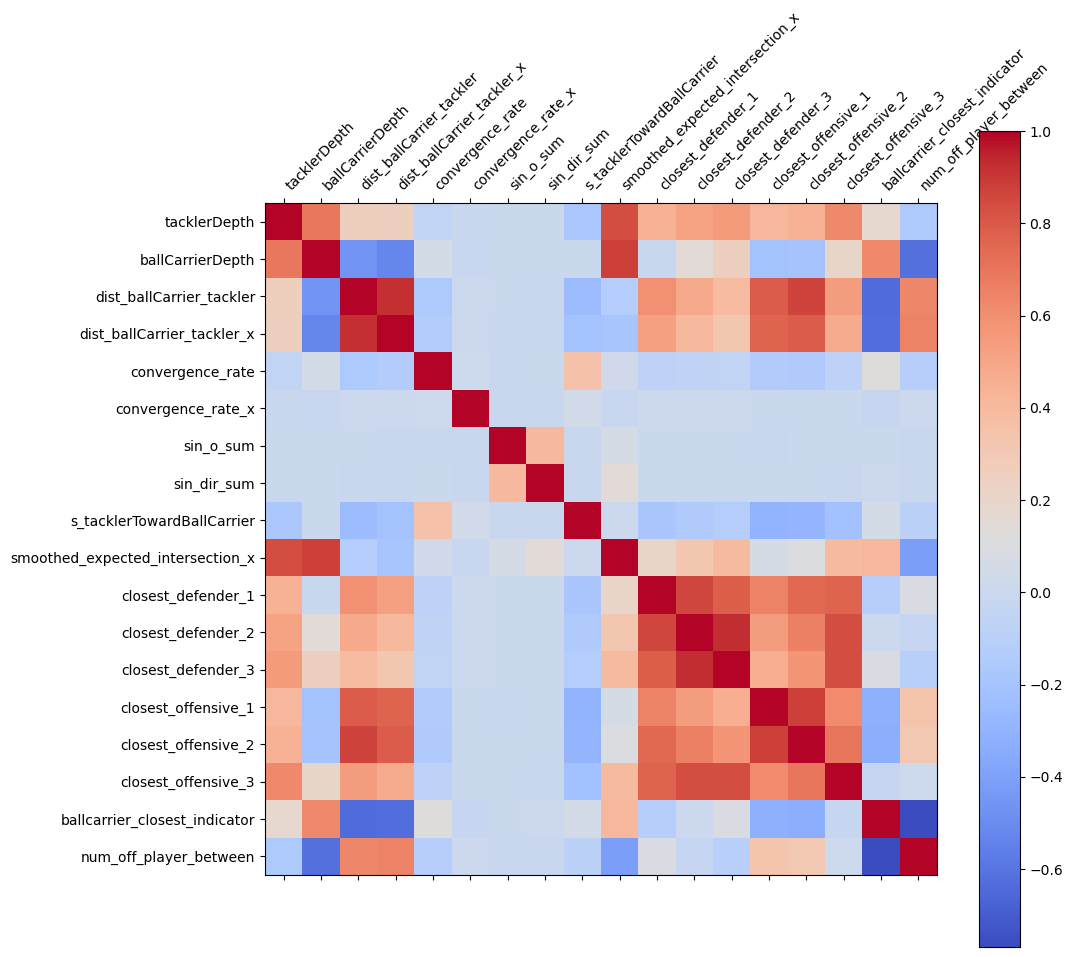

In [13]:
# Correlation Heatmap
correlation_matrix = x_subset.iloc[:,4:].corr()

fig, ax = plt.subplots(figsize=(12, 12))  # Adjust figure size
cax = ax.matshow(correlation_matrix, cmap='coolwarm')

plt.colorbar(cax)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))

ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='left')
ax.set_yticklabels(correlation_matrix.columns)

plt.gcf().subplots_adjust(bottom=0.2, left=0.2)
plt.show()

# Modeling
* LSTM Neural Network: with dynamic length due to each play having differing amounts of frames

##### Preprocess the data: split train (weeks 1-7) and test (weeks 8,9), standardize, and pad to constant frame length

In [14]:
# Merge x and y on the key columns
data = pd.concat([x_subset, y], axis=1).merge(df_games[['gameId', 'week']], on='gameId', how='left')
data = data.sort_values(['gameId', 'playId', 'tacklerId', 'frameId', 'week'], axis=0, ignore_index=True)

# Split the data first to avoid data leakage
X_all, y_all = data.iloc[:,4:-2], data.iloc[:,-2:-1]
train_data, test_data = data[data.week <= 7].iloc[:,:-1], data[data.week > 7].iloc[:,:-1]
X_train, y_train, = train_data.iloc[:,4:-1], train_data.iloc[:,-1:]
X_test, y_test = test_data.iloc[:,4:-1], test_data.iloc[:,-1:]
train_keys, test_keys, all_keys = train_data.iloc[:,:4], test_data.iloc[:,:4], data.iloc[:,:4]

# Replace inf/-inf with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_all.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
X_all.fillna(X_all.mean(), inplace=True)

# Standardize the features (assuming features start from the 4th column)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_all = scaler.transform(X_all)

# Group data by gameId, playId, and tacklerId
X_train_df = pd.DataFrame(X_train, index=train_data.index, columns=train_data.columns.values[4:-1])
X_test_df = pd.DataFrame(X_test, index=test_data.index, columns=train_data.columns.values[4:-1])
X_all_df = pd.DataFrame(X_all, index=data.index, columns=data.columns.values[4:-2])
train_data = pd.concat([train_keys,X_train_df, y_train],axis=1)
test_data = pd.concat([test_keys,X_test_df, y_test],axis=1)
all_data = pd.concat([all_keys, X_all_df, y_all], axis=1)
train_grouped = train_data.groupby(['gameId', 'playId', 'tacklerId'])
test_grouped = test_data.groupby(['gameId', 'playId', 'tacklerId'])
all_grouped = all_data.groupby(['gameId', 'playId', 'tacklerId'])

# Function to group and pad data
def prepare_data(grouped_data, padding_value=0):
    X, Y = [], []
    for _, group in grouped_data:
        X.append(group.iloc[:, 4:-1].values)
        Y.append(group['playResult'].values)
    X_padded = pad_sequences(X, maxlen=max_len, dtype='float32', padding='post', value=padding_value)
    Y_padded = pad_sequences(Y, maxlen=max_len, dtype='float32', padding='post', value=padding_value)
    Y_padded = np.expand_dims(Y_padded, -1)
    return X_padded, Y_padded

# Padding value set to a value substantially greater than a
padding_value = 10000

# Prepare input (X) and output (Y) for both training and testing sets
max_len = max([len(group) for _, group in train_grouped] + [len(group) for _, group in test_grouped])
X_train_full, Y_train_full = prepare_data(train_grouped, padding_value=padding_value)
X_test, Y_test = prepare_data(test_grouped, padding_value=padding_value)
X_all, Y_all = prepare_data(all_grouped, padding_value=padding_value)

In [15]:
# Split trian val data
idx = 8424 # Starting x-index of the week 6 games

# Train set: weeks 1-5
X_train = X_train_full[:idx]
Y_train = Y_train_full[:idx] 

# Val set: weeks 6,7
X_val = X_train_full[idx:] 
Y_val= Y_train_full[idx:]

In [16]:
optimizer = Adam(learning_rate=1e-3)

# Define the LSTM model
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_len, X_train_full.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(1)))  # Predicting one value per time step

# Custom loss function which masks out padded values in y before calculating loss
def masked_mean_squared_error(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, padding_value), K.floatx())
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask

    sq_error = K.square(y_pred_masked - y_true_masked)
    masked_sq_error = sq_error * mask

    mse = K.sum(masked_sq_error) / K.sum(mask)
    return mse

# Complile the model
model.compile(optimizer=optimizer, loss=masked_mean_squared_error)

In [18]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, 
                    validation_data=(X_val, Y_val), 
                    callbacks=[early_stopping])

Epoch 1/50
264/264 [==============================] - 7s 27ms/step - loss: 29.7778 - val_loss: 22.6132
Epoch 2/50
264/264 [==============================] - 7s 25ms/step - loss: 21.1803 - val_loss: 18.7174
Epoch 3/50
264/264 [==============================] - 7s 25ms/step - loss: 18.4049 - val_loss: 17.0656
Epoch 4/50
264/264 [==============================] - 7s 25ms/step - loss: 16.7875 - val_loss: 16.0699
Epoch 5/50
264/264 [==============================] - 7s 26ms/step - loss: 15.8867 - val_loss: 15.6348
Epoch 6/50
264/264 [==============================] - 7s 25ms/step - loss: 15.0875 - val_loss: 15.5408
Epoch 7/50
264/264 [==============================] - 7s 25ms/step - loss: 14.5774 - val_loss: 14.6288
Epoch 8/50
264/264 [==============================] - 7s 25ms/step - loss: 14.2739 - val_loss: 14.2764
Epoch 9/50
264/264 [==============================] - 7s 27ms/step - loss: 13.9314 - val_loss: 14.2330
Epoch 10/50
264/264 [==============================] - 7s 25ms/step - los

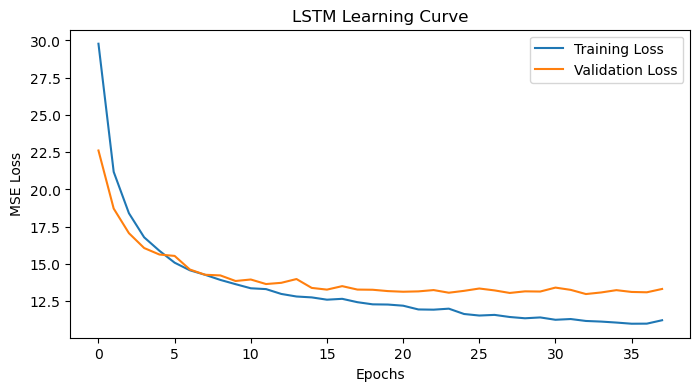

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [20]:
# Make predictions
predictions = model.predict(X_test)

95/95 [==============================] - 1s 5ms/step


In [21]:
# Calculate R-squared for all of non-padding frames of each sequence
true_arr = np.array([])
pred_arr = np.array([])
for y_true, y_pred in zip(Y_test, predictions):
    y_true = y_true.flatten()
    end_idx = len(y_true[y_true != padding_value])
    true_arr = np.append(true_arr, y_true[:end_idx])
    pred_arr = np.append(pred_arr, y_pred[:end_idx])

# Calculate R-squared for all non-padding frames of each sequence
r2_all_frames = r2_score(true_arr,pred_arr)
print(f'R-squared of all Test frames: {r2_all_frames}')

# Calculate MAE for the all non-padding frames of each sequence
true_arr = np.array([])
pred_arr = np.array([])
for y_true, y_pred in zip(Y_test, predictions):
    y_true = y_true.flatten()
    end_idx = len(y_true[y_true != padding_value])
    true_arr = np.append(true_arr, y_true[:end_idx])
    pred_arr = np.append(pred_arr, y_pred[:end_idx])

# Calculate MAE for the first 10 frames of each sequence
mae_all_frames = mean_absolute_error(true_arr,pred_arr)
print(f'MAE of all Test frames: {mae_all_frames}')

R-squared of all Test frames: 0.742082936629169
MAE of all Test frames: 2.2043720262099917


In [22]:
for i in [round(i * 0.1, 1) for i in range(10)]:
    true_arr = np.array([])
    pred_arr = np.array([])
    
    for cntr, (y_true, y_pred) in enumerate(zip(Y_test, predictions)):
        y_true = y_true.flatten()
        num_frames = len(y_true[y_true != padding_value])
        start_idx = int(np.floor(num_frames*i)) if (cntr%2)==0 else int(np.ceil(num_frames*i))
        end_idx = int(np.floor(num_frames*round(i+.1,1))) if (cntr%2)==0 else int(np.ceil(num_frames*round(i+.1,1)))
        if end_idx > num_frames:
            print("PROBLEM")
            break
        true_arr = np.append(true_arr, y_true[start_idx:end_idx])
        pred_arr = np.append(pred_arr, y_pred[start_idx:end_idx])

    r2_10pct_frames = r2_score(true_arr, pred_arr)
    print(f'R-squared of {i}th - {round(i+.1,1)}th percentile of frames: {r2_10pct_frames:.3f}')

R-squared of 0.0th - 0.1th percentile of frames: 0.462
R-squared of 0.1th - 0.2th percentile of frames: 0.502
R-squared of 0.2th - 0.3th percentile of frames: 0.550
R-squared of 0.3th - 0.4th percentile of frames: 0.626
R-squared of 0.4th - 0.5th percentile of frames: 0.728
R-squared of 0.5th - 0.6th percentile of frames: 0.814
R-squared of 0.6th - 0.7th percentile of frames: 0.890
R-squared of 0.7th - 0.8th percentile of frames: 0.935
R-squared of 0.8th - 0.9th percentile of frames: 0.957
R-squared of 0.9th - 1.0th percentile of frames: 0.959


In [23]:
for i in [round(i * 0.1, 1) for i in range(10)]:
    true_arr = np.array([])
    pred_arr = np.array([])
    
    for cntr, (y_true, y_pred) in enumerate(zip(Y_test, predictions)):
        y_true = y_true.flatten()
        num_frames = len(y_true[y_true != padding_value])
        start_idx = int(np.floor(num_frames*i)) if (cntr%2)==0 else int(np.ceil(num_frames*i))
        end_idx = int(np.floor(num_frames*round(i+.1,1))) if (cntr%2)==0 else int(np.ceil(num_frames*round(i+.1,1)))
        if end_idx > num_frames:
            print("PROBLEM")
            break
        true_arr = np.append(true_arr, y_true[start_idx:end_idx])
        pred_arr = np.append(pred_arr, y_pred[start_idx:end_idx])

    mae_10pct_frames = mean_absolute_error(true_arr, pred_arr)
    print(f'MAE of {i}th - {round(i+.1,1)}th percentile of frames: {mae_10pct_frames:.3f}')

MAE of 0.0th - 0.1th percentile of frames: 3.420
MAE of 0.1th - 0.2th percentile of frames: 3.270
MAE of 0.2th - 0.3th percentile of frames: 3.108
MAE of 0.3th - 0.4th percentile of frames: 2.858
MAE of 0.4th - 0.5th percentile of frames: 2.485
MAE of 0.5th - 0.6th percentile of frames: 2.072
MAE of 0.6th - 0.7th percentile of frames: 1.631
MAE of 0.7th - 0.8th percentile of frames: 1.253
MAE of 0.8th - 0.9th percentile of frames: 0.980
MAE of 0.9th - 1.0th percentile of frames: 0.968


In [24]:
# Make predictions on everything
pred_all = model.predict(X_all)

453/453 [==============================] - 3s 6ms/step


In [25]:
# Calculate R-squared for the last 10 non-padding frames of each sequence
r2_values = []
true_arr = np.array([])
pred_arr = np.array([])
for y_true, y_pred in zip(Y_all, pred_all):
    y_true = y_true.flatten()
    end_idx = len(y_true[y_true != padding_value])
    true_arr = np.append(true_arr, y_true[:end_idx])
    pred_arr = np.append(pred_arr, y_pred[:end_idx])

In [26]:
df_results = pd.concat([data.iloc[:,:-1],pd.DataFrame(pred_arr,columns=['pred_playResult'])],axis=1)

In [27]:
# Get r-squared percentiles for all data

r2_weights = {round(i * 0.1, 1):None for i in range(10)}
for i in [round(i * 0.1, 1) for i in range(10)]:
    true_arr = np.array([])
    pred_arr = np.array([])
    
    for cntr, (y_true, y_pred) in enumerate(zip(Y_all, pred_all)):
        y_true = y_true.flatten()
        num_frames = len(y_true[y_true != padding_value])
        start_idx = int(np.floor(num_frames*i)) if (cntr%2)==0 else int(np.ceil(num_frames*i))
        end_idx = int(np.floor(num_frames*round(i+.1,1))) if (cntr%2)==0 else int(np.ceil(num_frames*round(i+.1,1)))
        if end_idx > num_frames:
            print("PROBLEM")
            break
        true_arr = np.append(true_arr, y_true[start_idx:end_idx])
        pred_arr = np.append(pred_arr, y_pred[start_idx:end_idx])

    r2_10pct_frames = r2_score(true_arr, pred_arr)
    r2_weights[i] = (r2_10pct_frames)
    print(f'R-squared of {i}th - {round(i+.1,1)}th percentile of frames: {r2_10pct_frames:.3f}')

R-squared of 0.0th - 0.1th percentile of frames: 0.498
R-squared of 0.1th - 0.2th percentile of frames: 0.562
R-squared of 0.2th - 0.3th percentile of frames: 0.615
R-squared of 0.3th - 0.4th percentile of frames: 0.687
R-squared of 0.4th - 0.5th percentile of frames: 0.780
R-squared of 0.5th - 0.6th percentile of frames: 0.855
R-squared of 0.6th - 0.7th percentile of frames: 0.910
R-squared of 0.7th - 0.8th percentile of frames: 0.944
R-squared of 0.8th - 0.9th percentile of frames: 0.962
R-squared of 0.9th - 1.0th percentile of frames: 0.962


In [28]:
df_results.head()

,gameId,playId,frameId,tacklerId,tacklerDepth,ballCarrierDepth,dist_ballCarrier_tackler,dist_ballCarrier_tackler_x,convergence_rate,convergence_rate_x,sin_o_sum,sin_dir_sum,s_tacklerTowardBallCarrier,smoothed_expected_intersection_x,closest_defender_1,closest_defender_2,closest_defender_3,closest_offensive_1,closest_offensive_2,closest_offensive_3,ballcarrier_closest_indicator,num_off_player_between,playResult,pred_playResult
0,2022090800,56,1,43294,7.05,4.40,3.636289,2.65,1.000000,1.000000,1.291036,-0.032455,0.000000,5.769791,7.302089,10.278803,13.253396,3.636289,8.862878,9.949418,1,0,6,6.640768
1,2022090800,56,2,43294,6.98,4.52,3.528810,2.46,1.030458,1.077236,1.357581,-0.080710,1.074793,5.789183,6.834764,10.286622,12.521294,3.528810,7.433794,8.855399,1,0,6,6.355444
2,2022090800,56,3,43294,6.94,4.66,3.413210,2.28,1.033869,1.078947,1.389668,-0.169013,1.156004,5.825853,6.345589,10.250137,11.750426,3.413210,5.464795,8.867581,1,0,6,7.182916
3,2022090800,56,4,43294,6.90,4.81,3.258543,2.09,1.047465,1.090909,1.452390,-0.233436,1.546670,5.876112,5.817233,10.171981,10.900073,3.258543,3.289072,8.892497,1,0,6,7.747470
4,2022090800,56,5,43294,6.87,4.99,3.080260,1.88,1.057879,1.111702,1.500370,-0.294856,1.782829,5.935473,5.279593,10.020005,10.052920,1.904127,3.080260,8.940006,1,0,6,8.081655


In [29]:
df_results[['gameId','playId','frameId','tacklerId','playResult','pred_playResult']].to_pickle('data/predictions.pkl')

In [30]:
cols = ['gameId','playId','tacklerId','playResult']
df_score = df_results.drop_duplicates(['gameId','playId','tacklerId'],ignore_index=True)[cols]

In [32]:
df_results.reset_index(drop=True, inplace=True)
df_score.reset_index(drop=True, inplace=True)

# Calculateing Weighted Average of YSOE

In [33]:
# Yards Saved Over Expected
df_results['percentile'] = df_results.groupby(['gameId', 'playId', 'tacklerId'])['frameId'].rank(pct=True)

def map_to_weight(p):
    key = int(p * 10) / 10
    if key == 1.0:
        key = 0.9
    return r2_weights[key]

df_results['weight'] = df_results['percentile'].apply(map_to_weight)

def weighted_avg(group):
    return (group['pred_playResult'] * group['weight']).sum() / group['weight'].sum()

weighted_avg_results = df_results.groupby(['gameId', 'playId', 'tacklerId']).apply(weighted_avg).reset_index(name='weighted_pred_playResult')

df_score = df_score.merge(weighted_avg_results, on=['gameId', 'playId', 'tacklerId'], how='left')

df_score['YSOE'] = df_score['weighted_pred_playResult'] - df_score['playResult']

In [34]:
# Count the number of tackles for each tacklerId
tackle_counts = df_score['tacklerId'].value_counts().reset_index()
tackle_counts.columns = ['tacklerId', 'tackle_count']

# Merge this count with the df_score DataFrame
df_score = df_score.merge(tackle_counts, on='tacklerId', how='left')

In [35]:
df_score = df_score.merge(df_players[['nflId','displayName','position']].rename({'nflId':'tacklerId'},axis=1),on='tacklerId',how='left')

In [36]:
df_score.sort_values('YSOE').head()

,gameId,playId,tacklerId,playResult,weighted_pred_playResult,YSOE,tackle_count,displayName,position
9972,2022102000,1025,43986,64,36.967306,-27.032694,11,Antonio Hamilton,CB
14291,2022110610,544,46137,48,21.832692,-26.167308,35,Justin Reid,SS
14315,2022110610,1419,54486,56,31.341370,-24.658630,2,Trent McDuffie,CB
14314,2022110610,1419,52546,56,31.784411,-24.215589,50,L'Jarius Sneed,CB
7599,2022100907,938,54936,79,55.323438,-23.676562,32,Kader Kohou,CB


In [38]:
max_frameId = df_tracking.groupby(['gameId', 'playId'])['frameId'].max().reset_index()

# Merge this information back into the original dataframe 'df'
df_score = pd.merge(df_score, max_frameId, how='left', on=['gameId', 'playId'], suffixes=('', '_max'))
df_score['frameId_max'] = df_score['frameId']- 4

In [39]:
df_score.columns

Index(['gameId', 'playId', 'tacklerId', 'playResult',
       'weighted_pred_playResult', 'YSOE', 'tackle_count', 'displayName',
       'position', 'frameId', 'frameId_max'],
      dtype='object')

In [40]:
df_score = df_score[['gameId', 'playId', 'tacklerId', 'playResult',
       'weighted_pred_playResult', 'YSOE', 'tackle_count', 'displayName',
       'position', 'frameId_max']]

In [41]:
df_score.head()

,gameId,playId,tacklerId,playResult,weighted_pred_playResult,YSOE,tackle_count,displayName,position,frameId_max
0,2022090800,56,43294,6,7.656978,1.656978,30,Jalen Ramsey,CB,18
1,2022090800,80,53532,7,5.934091,-1.065909,49,Ernest Jones,ILB,26
2,2022090800,101,42816,7,6.294855,-0.705145,16,Troy Hill,CB,45
3,2022090800,122,38577,6,4.383524,-1.616476,60,Bobby Wagner,ILB,29
4,2022090800,146,38577,2,2.159442,0.159442,60,Bobby Wagner,ILB,52


In [185]:
df_score.to_pickle('data/score.pkl')

In [85]:
r2 = r2_score(df_score.playResult.to_numpy(),df_score.weighted_pred_playResult.to_numpy())
print(f'R-squared of Weighted Score: {r2:.4f}')

mae = mean_absolute_error(df_score.playResult.to_numpy(),df_score.weighted_pred_playResult.to_numpy())
print(f'MAE of Weighted Score: {mae:.4f}')

R-squared of Weighted Score: 0.9258
MAE of Weighted Score: 1.3596


# Clipping it to only plays with max 100 frames

In [87]:
df_tracking.drop_duplicates(['gameId','playId','frameId']).frameId.value_counts()

frameId
1      12486
2      12486
3      12486
4      12486
5      12486
6      12486
7      12486
8      12485
9      12485
11     12484
10     12484
12     12400
13     12238
14     12087
15     11923
16     11729
17     11546
18     11346
19     11149
20     10959
21     10761
22     10570
23     10360
24     10175
25     10003
26      9808
27      9597
28      9399
29      9168
30      8972
31      8786
32      8599
33      8434
34      8229
35      8056
36      7881
37      7732
38      7566
39      7378
40      7193
41      7006
42      6774
43      6571
44      6331
45      6070
46      5771
47      5449
48      5160
49      4857
50      4569
51      4256
52      3994
53      3720
54      3446
55      3183
56      2920
57      2672
58      2452
59      2232
60      2018
61      1831
62      1659
63      1488
64      1342
65      1220
66      1117
67      1008
68       900
69       798
70       710
71       645
72       593
73       540
74       487
75       440
76       394
77  

In [88]:
df_player_scores = df_score[['tacklerId','displayName','position']].drop_duplicates('tacklerId',ignore_index=True)

In [89]:
df_player_scores.head()

,tacklerId,displayName,position
0,43294,Jalen Ramsey,CB
1,53532,Ernest Jones,ILB
2,42816,Troy Hill,CB
3,38577,Bobby Wagner,ILB
4,43335,A'Shawn Robinson,DT


In [90]:
avg_YSOE_per_tackler = df_score.groupby('tacklerId')['YSOE'].mean().reset_index()
df_player_scores = df_player_scores.merge(avg_YSOE_per_tackler, on='tacklerId', how='left')

In [91]:
df_player_scores.rename({'YSOE':'Avg_YSOE'},axis=1, inplace=True)

In [92]:
df_player_scores = df_player_scores.merge(df_score[['tacklerId','tackle_count']],on='tacklerId',how='left').drop_duplicates('tacklerId',ignore_index=True)

In [93]:
df_player_scores['Avg_YSOE'] = df_player_scores['Avg_YSOE'].round(3)


In [94]:
df_player_scores_new = df_player_scores.query('tackle_count >= 10').sort_values('Avg_YSOE',ascending=False)

In [95]:
df_player_scores_new.reset_index(inplace=True, drop=True)

In [96]:
df_player_scores_new.head(15)

,tacklerId,displayName,position,Avg_YSOE,tackle_count
0,35459,Kareem Jackson,SS,1.503,45
1,42421,P.J. Williams,CB,1.492,10
2,52607,Jordan Fuller,SS,1.377,11
3,42543,Quandre Diggs,FS,1.365,35
4,53465,Jevon Holland,FS,1.265,44
5,53533,Brandon Stephens,FS,1.238,14
6,35452,Brandon Graham,DE,1.220,12
7,44862,Justin Evans,SS,1.209,21
8,47888,Chauncey Gardner-Johnson,SS,1.183,40
9,52510,Alex Highsmith,OLB,1.120,22


In [114]:
df_player_scores_new = df_player_scores_new.merge(df_tracking[['nflId','club']].rename({'nflId':'tacklerId'},axis=1),how='left',on='tacklerId').drop_duplicates('tacklerId',ignore_index=True)

In [115]:
df_player_scores_new.to_pickle('scores.pkl')

In [116]:
df_player_scores_new = pd.read_pickle('scores.pkl')

In [188]:
df_player_scores_new.position.unique()

array(['SS', 'CB', 'FS', 'DE', 'OLB', 'MLB', 'DT', 'ILB', 'NT', 'DB'],
      dtype=object)

In [189]:
defensive_backs = ['CB','DB','SS','FS']
linebackers = ['MLB','ILB','OLB']
defensive_line = ['DT','DE','NT']

In [190]:
df_player_scores_new.sort_values('Avg_YSOE', ignore_index=True,axis=0, ascending=False).head()

,tacklerId,displayName,position,Avg_YSOE,tackle_count,club
0,35459,Kareem Jackson,SS,1.503,45,DEN
1,42421,P.J. Williams,CB,1.492,10,NO
2,52607,Jordan Fuller,SS,1.377,11,LA
3,42543,Quandre Diggs,FS,1.365,35,SEA
4,53465,Jevon Holland,FS,1.265,44,MIA


In [191]:
df_db = df_player_scores_new.query('position in @defensive_backs').sort_values('Avg_YSOE', ignore_index=True,axis=0, ascending=False)
df_lb = df_player_scores_new.query('position in @linebackers').sort_values('Avg_YSOE', ignore_index=True,axis=0, ascending=False)
df_dl = df_player_scores_new.query('position in @defensive_line').sort_values('Avg_YSOE', ignore_index=True,axis=0, ascending=False)

In [192]:
df_db.insert(0, 'rank', range(1, len(df_db) + 1))
df_lb.insert(0, 'rank', range(1, len(df_lb) + 1))
df_dl.insert(0, 'rank', range(1, len(df_dl) + 1))

In [193]:
# Get top and bottom 10
df_db = pd.concat([df_db.head(10), df_db.tail(10)]).sort_values('Avg_YSOE', ignore_index=True,axis=0, ascending=True)
df_lb = pd.concat([df_lb.head(10), df_lb.tail(10)]).sort_values('Avg_YSOE', ignore_index=True,axis=0, ascending=True)
df_dl = pd.concat([df_dl.head(10), df_dl.tail(10)]).sort_values('Avg_YSOE', ignore_index=True,axis=0, ascending=True)

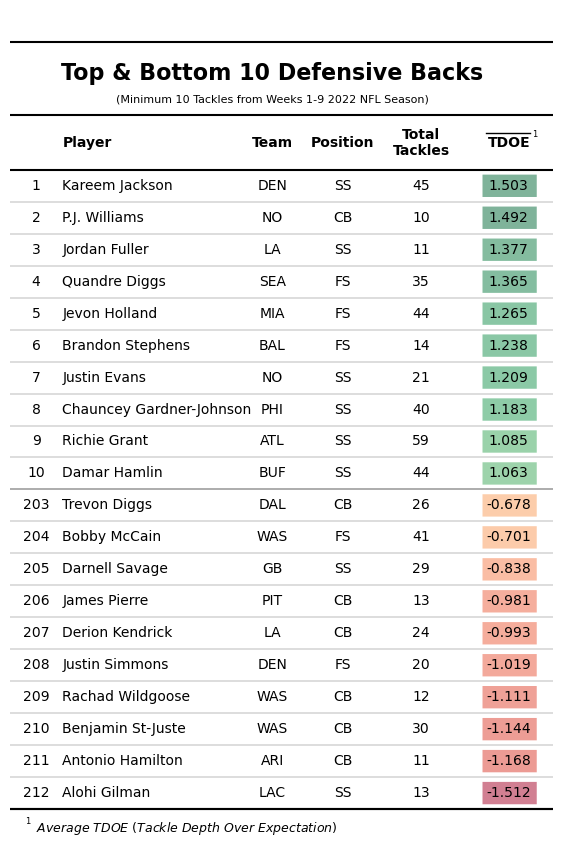

In [194]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches


fig = plt.figure(figsize=(7,11), dpi=100)
ax = plt.subplot()

ncols = 5
nrows = 20

ax.set_xlim(0, 3.1)
ax.set_ylim(-1.5, nrows + 5)

idx_col1 = 1.5
idx_col2 = idx_col1 + .4
positions = [0.15, .3,idx_col1, idx_col2, idx_col2+.45, idx_col2+.95]
columns = ['rank','displayName','club', 'position', 'tackle_count', 'Avg_YSOE']

# Define colormap
cmap = plt.cm.RdYlGn
norm = mcolors.Normalize(vmin=df_db.iloc[:nrows]['Avg_YSOE'].min(), vmax=df_db['Avg_YSOE'].max())

# Add table's main text and colored rectangles
for i in range(nrows):
    for j, column in enumerate(columns):
        ha = 'left' if j == 1 else 'center'
        text_label = df_db[column].iloc[i]
        weight = 'normal'

        if column == 'Avg_YSOE':
            # Format 'Avg_YSOE' with 3 decimal places
            text_label = f"{df_db[column].iloc[i]:.3f}"
            # Use colormap
            color = cmap(norm(df_db[column].iloc[i]))
            # Draw rectangle
            rect = patches.FancyBboxPatch((positions[j]-.15, i+.15), .31, 1-.3, linewidth=0, 
                                           boxstyle="Round, pad=0",
                                           edgecolor='none', facecolor=color, alpha=0.5)
            ax.add_patch(rect)
        else:
            color = 'black'  # Default text color for other columns

        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight,
            color=color if column != 'Avg_YSOE' else 'black'
        )

# Compute the midpoint for vertical centering
midpoint = (nrows + nrows + 1.7) / 2

# Add column names
column_names = ['','Player', 'Team', 'Position', 'Total\nTackles','TDOE']
for index, c in enumerate(column_names):
    if index == 1:
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[index], midpoint),  # Use midpoint for vertical centering
        text=column_names[index],
        ha=ha,
        va='center',  # Changed from 'bottom' to 'center'
        weight='bold',
    )


# Plot Title and Subtitle
ax.annotate(
    xy=(1.5,23),
    text='Top & Bottom 10 Defensive Backs',
    ha='center',
    size=16,
    va='center',
    weight='bold',
)
ax.annotate(
    xy=(1.5,22.2),
    text='(Minimum 10 Tackles from Weeks 1-9 2022 NFL Season)',
    ha='center',
    size=8,
    va='center',
)

# Line above YSOE
ax.plot([idx_col2+.82, idx_col2+1.07], [nrows+1.15, nrows+1.15], lw=1, color='black', marker='', zorder=4)

# Add text for more info on Average TYSOE
ax.annotate(
    xy=(3,21.1),
    text='1',
    ha=ha,
    size=6,
    va='center',
    weight=weight,
)
ax.annotate(
    xy=(.1,-.4),
    text='1',
    ha='center',
    size=6,
    va='center',
    weight=weight,
)
ax.annotate(
    xy=(.15,-.6),
    text='$\it{Average\ TDOE\ (Tackle\ Depth\ Over\ Expectation)}$',
    ha='left',
    size=9,
    va='center',
    weight=weight,
)

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows+4, nrows+4], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows+1.7, nrows+1.7], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.1, color='lightgray', zorder=3 , marker='')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [10, 10], lw=1.3, color='darkgray', zorder=3 , marker='')

ax.set_axis_off()

plt.savefig('./db.png', dpi=300, bbox_inches='tight')
plt.show()

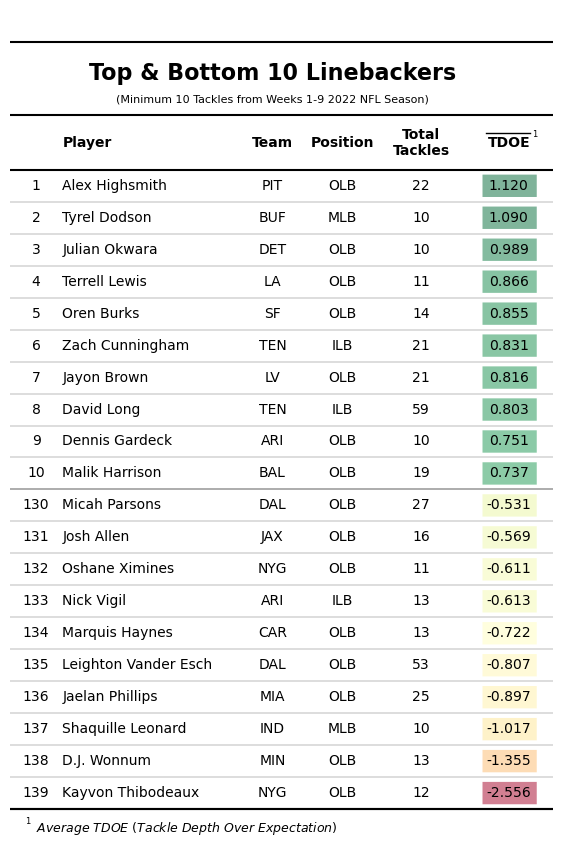

In [195]:
fig = plt.figure(figsize=(7,11), dpi=100)
ax = plt.subplot()

ncols = 5
nrows = 20

ax.set_xlim(0, 3.1)
ax.set_ylim(-1.5, nrows + 5)

idx_col1 = 1.5
idx_col2 = idx_col1 + .4
positions = [0.15, .3,idx_col1, idx_col2, idx_col2+.45, idx_col2+.95]
columns = ['rank','displayName','club', 'position', 'tackle_count', 'Avg_YSOE']

# Define colormap
cmap = plt.cm.RdYlGn
norm = mcolors.Normalize(vmin=df_lb.iloc[:nrows]['Avg_YSOE'].min(), vmax=df_lb['Avg_YSOE'].max())

# Add table's main text and colored rectangles
for i in range(nrows):
    for j, column in enumerate(columns):
        ha = 'left' if j == 1 else 'center'
        text_label = df_lb[column].iloc[i]
        weight = 'normal'

        if column == 'Avg_YSOE':
            # Format 'Avg_YSOE' with 3 decimal places
            text_label = f"{df_lb[column].iloc[i]:.3f}"
            # Use colormap
            color = cmap(norm(df_lb[column].iloc[i]))
            # Draw rectangle
            rect = patches.FancyBboxPatch((positions[j]-.15, i+.15), .31, 1-.3, linewidth=0, 
                                           boxstyle="Round, pad=0",
                                           edgecolor='none', facecolor=color, alpha=0.5)
            ax.add_patch(rect)
        else:
            color = 'black'  # Default text color for other columns

        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight,
            color=color if column != 'Avg_YSOE' else 'black'
        )

# Compute the midpoint for vertical centering
midpoint = (nrows + nrows + 1.7) / 2

# Add column names
column_names = ['','Player', 'Team', 'Position', 'Total\nTackles','TDOE']
for index, c in enumerate(column_names):
    if index == 1:
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[index], midpoint),  # Use midpoint for vertical centering
        text=column_names[index],
        ha=ha,
        va='center',  # Changed from 'bottom' to 'center'
        weight='bold',
    )


# Plot Title and Subtitle
ax.annotate(
    xy=(1.5,23),
    text='Top & Bottom 10 Linebackers',
    ha='center',
    size=16,
    va='center',
    weight='bold',
)
ax.annotate(
    xy=(1.5,22.2),
    text='(Minimum 10 Tackles from Weeks 1-9 2022 NFL Season)',
    ha='center',
    size=8,
    va='center',
)

# Line above YSOE
ax.plot([idx_col2+.82, idx_col2+1.07], [nrows+1.15, nrows+1.15], lw=1, color='black', marker='', zorder=4)

# Add text for more info on Average TYSOE
ax.annotate(
    xy=(3,21.1),
    text='1',
    ha=ha,
    size=6,
    va='center',
    weight=weight,
)
ax.annotate(
    xy=(.1,-.4),
    text='1',
    ha='center',
    size=6,
    va='center',
    weight=weight,
)
ax.annotate(
    xy=(.15,-.6),
    text='$\it{Average\ TDOE\ (Tackle\ Depth\ Over\ Expectation)}$',
    ha='left',
    size=9,
    va='center',
    weight=weight,
)

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows+4, nrows+4], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows+1.7, nrows+1.7], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.1, color='lightgray', zorder=3 , marker='')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [10, 10], lw=1.3, color='darkgray', zorder=3 , marker='')

ax.set_axis_off()

plt.savefig('./lb.png', dpi=300, bbox_inches='tight')
plt.show()

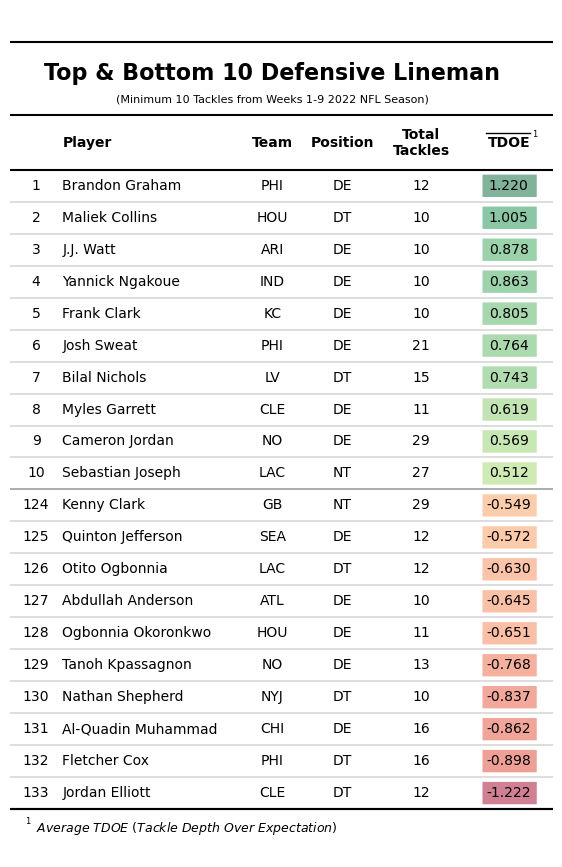

In [196]:
fig = plt.figure(figsize=(7,11), dpi=100)
ax = plt.subplot()

ncols = 5
nrows = 20

ax.set_xlim(0, 3.1)
ax.set_ylim(-1.5, nrows + 5)

idx_col1 = 1.5
idx_col2 = idx_col1 + .4
positions = [0.15, .3,idx_col1, idx_col2, idx_col2+.45, idx_col2+.95]
columns = ['rank','displayName','club', 'position', 'tackle_count', 'Avg_YSOE']

# Define colormap
cmap = plt.cm.RdYlGn
norm = mcolors.Normalize(vmin=df_dl.iloc[:nrows]['Avg_YSOE'].min(), vmax=df_dl['Avg_YSOE'].max())

# Add table's main text and colored rectangles
for i in range(nrows):
    for j, column in enumerate(columns):
        ha = 'left' if j == 1 else 'center'
        text_label = df_dl[column].iloc[i]
        weight = 'normal'

        if column == 'Avg_YSOE':
            # Format 'Avg_YSOE' with 3 decimal places
            text_label = f"{df_dl[column].iloc[i]:.3f}"
            # Use colormap
            color = cmap(norm(df_dl[column].iloc[i]))
            # Draw rectangle
            rect = patches.FancyBboxPatch((positions[j]-.15, i+.15), .31, 1-.3, linewidth=0, 
                                           boxstyle="Round, pad=0",
                                           edgecolor='none', facecolor=color, alpha=0.5)
            ax.add_patch(rect)
        else:
            color = 'black'  # Default text color for other columns

        ax.annotate(
            xy=(positions[j], i + .5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight,
            color=color if column != 'Avg_YSOE' else 'black'
        )

# Compute the midpoint for vertical centering
midpoint = (nrows + nrows + 1.7) / 2

# Add column names
column_names = ['','Player', 'Team', 'Position', 'Total\nTackles','TDOE']
for index, c in enumerate(column_names):
    if index == 1:
        ha = 'left'
    else:
        ha = 'center'
    ax.annotate(
        xy=(positions[index], midpoint),  # Use midpoint for vertical centering
        text=column_names[index],
        ha=ha,
        va='center',  # Changed from 'bottom' to 'center'
        weight='bold',
    )


# Plot Title and Subtitle
ax.annotate(
    xy=(1.5,23),
    text='Top & Bottom 10 Defensive Lineman',
    ha='center',
    size=16,
    va='center',
    weight='bold',
)
ax.annotate(
    xy=(1.5,22.2),
    text='(Minimum 10 Tackles from Weeks 1-9 2022 NFL Season)',
    ha='center',
    size=8,
    va='center',
)

# Line above YSOE
ax.plot([idx_col2+.82, idx_col2+1.07], [nrows+1.15, nrows+1.15], lw=1, color='black', marker='', zorder=4)

# Add text for more info on Average TYSOE
ax.annotate(
    xy=(3,21.1),
    text='1',
    ha=ha,
    size=6,
    va='center',
    weight=weight,
)
ax.annotate(
    xy=(.1,-.4),
    text='1',
    ha='center',
    size=6,
    va='center',
    weight=weight,
)
ax.annotate(
    xy=(.15,-.6),
    text='$\it{Average\ TDOE\ (Tackle\ Depth\ Over\ Expectation)}$',
    ha='left',
    size=9,
    va='center',
    weight=weight,
)

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows+4, nrows+4], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows+1.7, nrows+1.7], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.1, color='lightgray', zorder=3 , marker='')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [10, 10], lw=1.3, color='darkgray', zorder=3 , marker='')

ax.set_axis_off()

plt.savefig('./dl.png', dpi=300, bbox_inches='tight')
plt.show()